In [11]:
logGC = open("output.log", "r")
#logGC = open("teste.log", "r")
PADRAO_OCORRENCIA_GC = "\S+\s+\d+\s+\w+.+average.+current.+"
PADRAO_OCUPACAO_MEM = "\S+\s+.+used.+available.+"


In [12]:
ocorrenciagc={
    'ocorrencia':[],
    'timestampstart': [],
    'type':[],
    'heapusedbefore':[],
    'heapallocatedbefore':[],
    'heapusedafter':[],
    'heapallocatedafter':[],
    'duration':[],
    'reason': []    
}
ocupacaomem={
    'coleta':[],
    'regiao': [],
    'used':[],
    'available':[],
    'committed':[]
}
contatodorcoleta = 0
ocgc = 1

def capturarocorrenciasgc(line, ocgc):
    splitline = line.split()
    ocorrenciagc['ocorrencia'].append(ocgc)
    ocorrenciagc['timestampstart'].append(splitline[1])
    ocorrenciagc['type'].append(splitline[3])
    ocorrenciagc['heapusedbefore'].append(float(splitline[4]))
    ocorrenciagc['heapallocatedbefore'].append(float(splitline[5][1:-1]))
    ocorrenciagc['heapusedafter'].append(float(splitline[7]))
    ocorrenciagc['heapallocatedafter'].append(float(splitline[8][1:-1]))
    ocorrenciagc['duration'].append(float(splitline[10]))
    ocorrenciagc['reason'].append(splitline[-1])
    ocgc +=1
    return ocgc

def capturarocupacaomem(line, coleta):
    splitline = line.split(',')
    ocupacaomem['regiao'].append(splitline[0].split(']')[1][1:])
    ocupacaomem['used'].append(float(splitline[1].split()[1]))
    ocupacaomem['available'].append(float(splitline[2].split()[1]))
    try:
        ocupacaomem['committed'].append(float(splitline[3].split()[1]))
        
    except:
        ocupacaomem['committed'].append(0)
        coleta +=1
    ocupacaomem['coleta'].append(coleta)
    return coleta
    
for line in logGC:
    result = re.match(PADRAO_OCORRENCIA_GC, line)
    if result:
        ocgc = capturarocorrenciasgc(line, ocgc)
    result = re.match(PADRAO_OCUPACAO_MEM, line)
    if result:
        contatodorcoleta = capturarocupacaomem(line, contatodorcoleta)
dfgc = pd.DataFrame(ocorrenciagc) 
dfgc = dfgc.set_index('ocorrencia')
dfmem = pd.DataFrame(ocupacaomem)
dfmem = dfmem.set_index('coleta') 

Text(0.5,1,'Heap Used [MB] After GC X [Mark-sweep]')

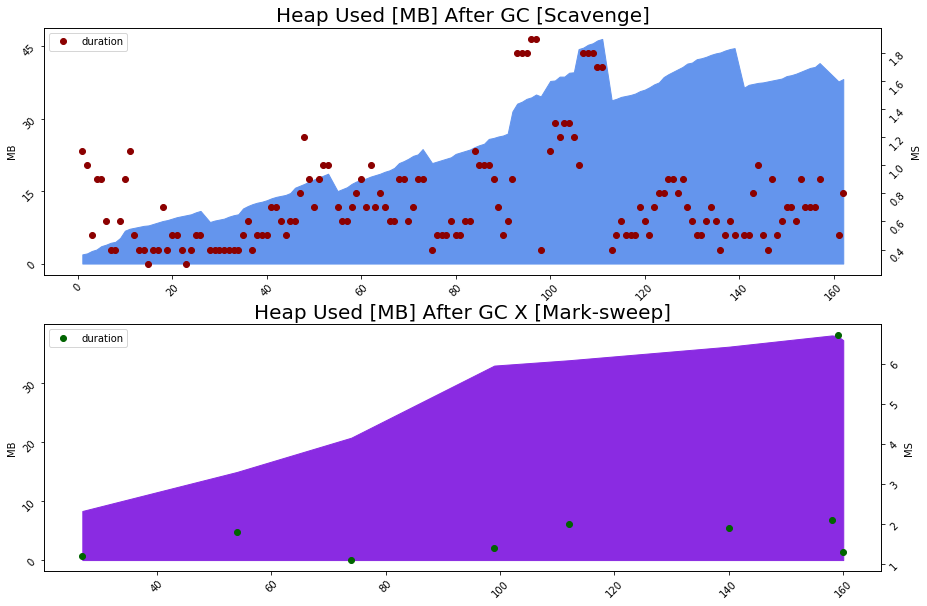

In [52]:
filtroScavenge = dfgc.loc[(dfgc['type'].str.contains('Scavenge') == True )]
filtromark = dfgc.loc[(dfgc['type'].str.contains('Mark-sweep') == True )]


fig, graficos = plt.subplots(2,1, figsize=(15,10))
legendas = ["Scavenge"]
graficos[0].stackplot(filtroScavenge.index, 
                      filtroScavenge['heapusedafter'], 
                      color='cornflowerblue', 
                      labels=legendas)
graficos[0].set_ylabel("MB")
graficos[0].tick_params(labelrotation=45)
graficos[0].yaxis.set_major_locator(plt.MaxNLocator(5))

grafico2 = graficos[0].twinx() 
grafico2.plot(filtroScavenge.index, filtroScavenge['duration'], 'ro',color='darkred')
grafico2.set_ylabel("MS")
grafico2.tick_params(labelrotation=45)
grafico2.legend(loc='upper left')
plt.title('Heap Used [MB] After GC [Scavenge]', fontsize=20)


legendas = ["Mark-sweep"]
graficos[1].stackplot(filtromark.index, 
                      filtromark['heapusedafter'], 
                      color='blueviolet', 
                      labels=legendas)
graficos[1].set_ylabel("MB")
graficos[1].tick_params(labelrotation=45)
graficos[1].yaxis.set_major_locator(plt.MaxNLocator(5))
#ax1.legend(loc='upper left')



grafico4 = graficos[1].twinx() 
grafico4.plot(filtromark.index, filtromark['duration'], 'ro',color='darkgreen')
grafico4.set_ylabel("MS")
grafico4.tick_params(labelrotation=45)
grafico4.legend(loc='upper left')

plt.title('Heap Used [MB] After GC X [Mark-sweep]', fontsize=20)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Text(0.5,1,'Ocupacao de Memoria em KB')

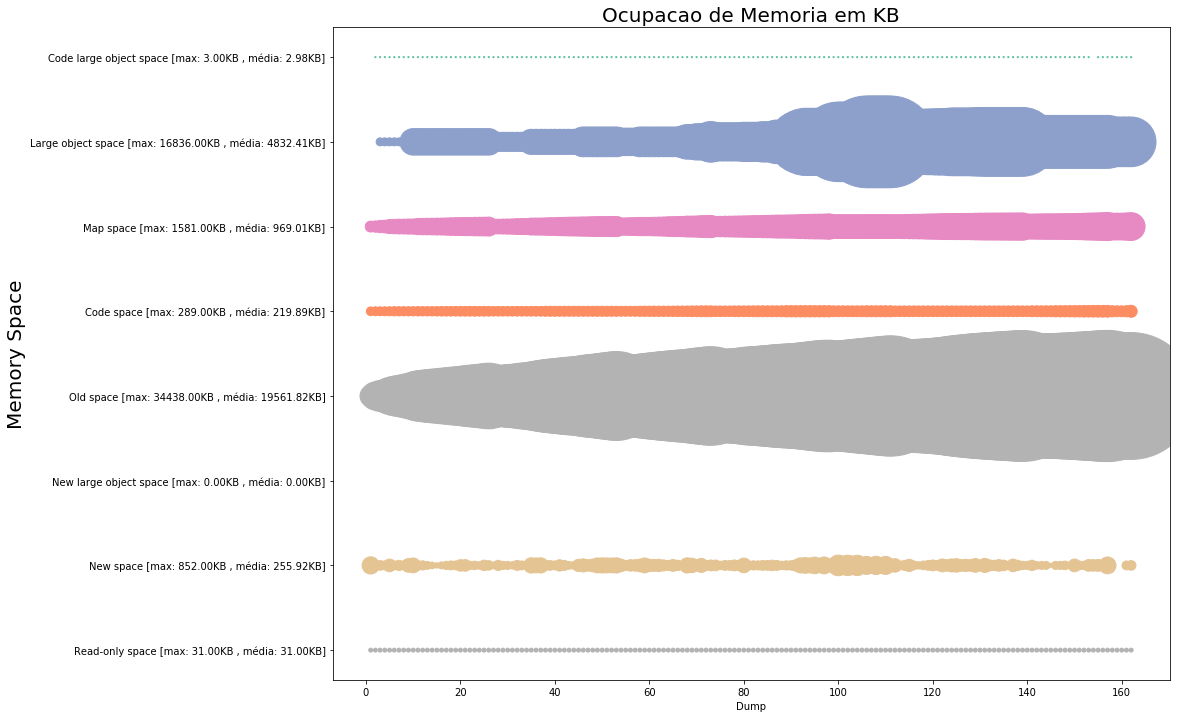

In [26]:
gpmemoryspace = dfmem.groupby(['regiao']).agg({
        'used': ['count', 'max', 'mean']
    })
gpmemoryspace.columns = ['Coletas', 'max', 'avg']
gpmemoryspace['Indice'] =  np.arange(len(gpmemoryspace))
gpmemoryspace = gpmemoryspace.reset_index()


filtro = dfmem.loc[(dfmem['regiao'].str.contains('All spaces') == False )
                  & (dfmem['regiao'].str.contains('Memory allocator') == False )]

def returnindice(memspace):
    found = gpmemoryspace.loc[gpmemoryspace['regiao'] ==  memspace]
    return found['Indice'].values[0]

def returnnome(memspace):
    found = gpmemoryspace.loc[gpmemoryspace['regiao'] ==  memspace]
    result = '%s [max: %.2fKB , média: %.2fKB]' %(found['regiao'].values[0], found['max'].values[0], found['avg'].values[0])
    return result

filtro['Indice'] = [returnindice(x) for x in filtro['regiao'].values]
filtro['regiaonome'] = [returnnome(x) for x in filtro['regiao'].values]

fig, ax = plt.subplots(1,1, figsize=(15,12))
filtro = filtro.reset_index()

sctr = ax.scatter(x=filtro['coleta'], y=filtro['regiaonome'], c=filtro['Indice'], s=filtro['used']/2, cmap='Set2')
plt.xlabel('Dump')
plt.ylabel('Memory Space', fontsize=20)
plt.title('Ocupacao de Memoria em KB', fontsize=20)
#plt.legend(loc='center left', bbox_to_anchor=(1.1, 0.5), labelspacing=3)
#plt.colorbar(sctr, ax=ax1, format='$%d')
#plt.colorbar(sctr, ax=ax, format='$%d')

Text(0.5,1,'Distribuição Tipo de GC')

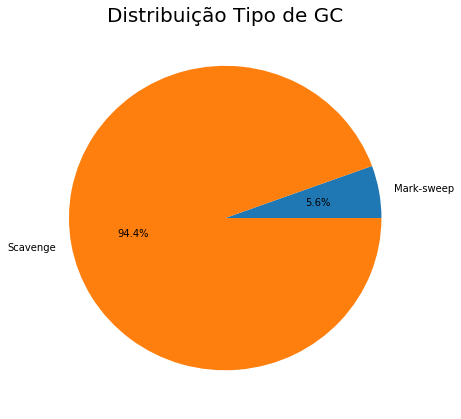

In [27]:
gpgc = dfgc.groupby(['type']).agg({    
                'type': ['count'],
                'timespentexternalcallbacks': ['mean', 'max']
    })
gpgc.columns = ['count', 'avg', 'max' ]
fig, axs = plt.subplots(1, 1, figsize=(7, 7))
grfc1 = axs.pie(gpgc['count'], 
                autopct='%1.1f%%', 
                labels=gpgc.index)
plt.title('Distribuição Tipo de GC', fontsize=20)

In [1]:
from datetime import datetime
import pytz
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
%matplotlib inline
import re
import pandas as pd
import numpy as np
import matplotlib.dates as dates
import IPython
from IPython.core.display import HTML
from IPython.display import Image
import IPython.core.display as di
import matplotlib.cm as cm